Objective: Reproduce results for the model trained on MIXED-RAND and tested on the 5 datasets with correct foreground images (left part of Figure 5).



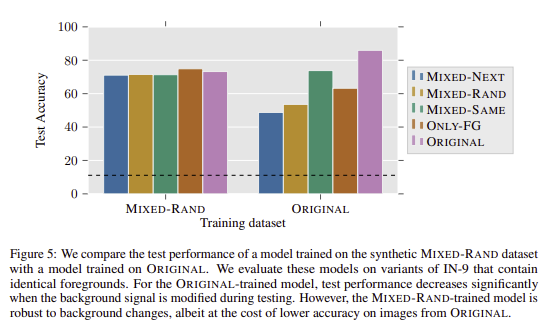

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader

from google.colab import files
plt.ion()   # interactive mode


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks/Reproducability Challenge DL


/content/drive/MyDrive/Colab Notebooks/Reproducability Challenge DL


In [ ]:
#unzipping the data
!tar -xvf mixed_rand.tar.gz

In [ ]:
#!ls mixed_rand/train

**Loading the data**

In [ ]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
                               
train_mixed_rand = datasets.ImageFolder("mixed_rand/train", transform=transform)
test_mixed_rand = datasets.ImageFolder("data/mixed_rand/val", transform=transform)
test_mixed_next = datasets.ImageFolder("data/mixed_next/val", transform=transform)
test_mixed_same = datasets.ImageFolder("data/mixed_same/val", transform=transform)
test_only_fg = datasets.ImageFolder("data/only_fg/val", transform=transform)
test_original = datasets.ImageFolder("data/original/val", transform=transform)


dataloaders={"train_mixed_rand":  DataLoader(train_mixed_rand, batch_size=256, shuffle=True),
             "test_mixed_rand":   DataLoader(test_mixed_rand, batch_size=256, shuffle=True),
             "test_mixed_next":   DataLoader(test_mixed_next, batch_size=256, shuffle=True),
             "test_mixed_same":   DataLoader(test_mixed_same, batch_size=256, shuffle=True),
             "test_only_fg":      DataLoader(test_only_fg, batch_size=256, shuffle=True),
             "test_original":     DataLoader(test_original, batch_size=256, shuffle=True)}

dataset_sizes={"train_mixed_rand":  len(train_mixed_rand),
               "test_mixed_rand":   len(test_mixed_rand),
               "test_mixed_next":   len(test_mixed_next),
               "test_mixed_same":   len(test_mixed_same),
               "test_only_fg":      len(test_only_fg),
               "test_original":     len(test_original)}


class_names=train_mixed_rand.classes



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Visualize a few images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


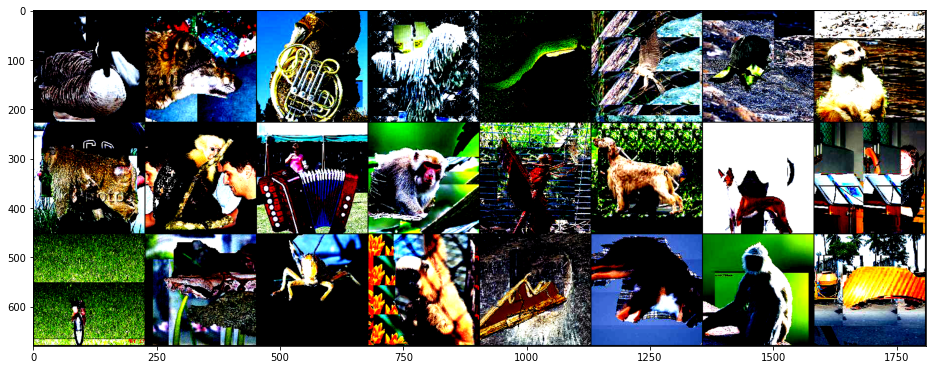

In [ ]:
samples, labels = iter(dataloaders['train_mixed_rand']).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

**Training function**

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=30):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train_mixed_rand","test_mixed_rand"]:
            if phase == "train_mixed_rand":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train_mixed_rand"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train_mixed_rand":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))



        print()


    #torch.save(model.state_dict(), "mixed_rand_resnet34_30_epochs_adam.weights")

    #files.download("mixed_rand_resnet34_30_epochs_adam.weights")

    return model 

**Testing function**

In [ ]:
def test_model(model, criterion, optimizer, num_epochs=1):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["test_mixed_rand","test_mixed_next", "test_mixed_same", "test_only_fg", "test_original"]:
            if phase == "train_mixed_rand":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train_mixed_rand"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train_mixed_rand":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))



        print()


    return model 

**ResNet18 (Training Phase)**

In [ ]:
model= models.resnet18(pretrained=False)

In [ ]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [ ]:
model.fc = nn.Sequential(
               nn.Linear(model.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9))

In [ ]:
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 9) #9 classes

In [ ]:
model.load_state_dict(torch.load("ResNet18 weights/mixed_rand_resnet18_30_epochs_sgd.weights"))

<All keys matched successfully>

In [ ]:
model=model.to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#! pip install torchbearer

import torchbearer
from torchbearer import Trial
from torch import optim


trial = Trial(model, optimizer, criterion, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(dataloaders["train_mixed_rand"], test_generator=dataloaders["test_mixed_rand"])
trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print()
print(results)

torch.save(model.state_dict(), "mixed_rand_resnet18_20_epochs_sgd.weights")

from google.colab import files
files.download('mixed_rand_resnet18_20_epochs_sgd.weights')

after 30 epochs overfits

**ResNet18 (Testing on the 5 datasets)**

In [ ]:
model=test_model(model, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
test_mixed_rand Loss: 1.9459 Acc: 0.3800
test_mixed_next Loss: 1.9544 Acc: 0.3625
test_mixed_same Loss: 1.9915 Acc: 0.3689
test_only_fg Loss: 1.9638 Acc: 0.3504
test_original Loss: 2.1525 Acc: 0.3351



ResNet18 trained on mixed rand with batch size =256 and SGD for **30 *epochs***:
*   test_mixed_rand Loss: 1.9459 Acc: 0.3800
*test_mixed_next Loss: 1.9544 Acc: 0.3625
*test_mixed_same Loss: 1.9915 Acc: 0.3689
*test_only_fg Loss: 1.9638 Acc: 0.3504
*test_original Loss: 2.1525 Acc: 0.3351



Similar pattern with the results in the original figure 5 but lower scores. 

  Let's try a bigger model and see if there is any improvement in the performance.

**ResNet34 (Training)**

In [ ]:
model= models.resnet34(pretrained=False)

In [ ]:
model.fc = nn.Sequential(
               nn.Linear(model.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9))

In [ ]:
model.load_state_dict(torch.load("mixed_rand_resnet34_20_epochs_sgd.weights", map_location=lambda device, loc: device))

<All keys matched successfully>

In [ ]:
model=model.to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
! pip install torchbearer

import torchbearer
from torchbearer import Trial
from torch import optim

for i in range(3):

  trial = Trial(model, optimizer, criterion, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(dataloaders["train_mixed_rand"], test_generator=dataloaders["test_mixed_rand"])
  trial.run(epochs=20)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  print()
  print(results)

  torch.save(model.state_dict(), "mixed_rand_resnet34_20_epochs_adam.weights")

  from google.colab import files
  files.download(f"mixed_rand_resnet34_20_epochs_adam.weights")

after 20 epochs overfits

**ResNet34 (Testing on the 5 datasets)**

In [ ]:
#ResNet34 10 epochs
model=test_model(model, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
test_mixed_rand Loss: 1.5368 Acc: 0.4593
test_mixed_next Loss: 1.5475 Acc: 0.4600
test_mixed_same Loss: 1.5299 Acc: 0.4736
test_only_fg Loss: 1.7467 Acc: 0.4030
test_original Loss: 1.7231 Acc: 0.4000



In [ ]:
#ResNet34 16 epochs
model=test_model(model, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
test_mixed_rand Loss: 1.6602 Acc: 0.5336
test_mixed_next Loss: 1.6895 Acc: 0.5269
test_mixed_same Loss: 1.6338 Acc: 0.5425
test_only_fg Loss: 1.6359 Acc: 0.4980
test_original Loss: 1.7288 Acc: 0.4825



In [ ]:
#ResNet34 20 epochs
model=test_model(model, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------
test_mixed_rand Loss: 2.4015 Acc: 0.5378
test_mixed_next Loss: 2.5049 Acc: 0.5370
test_mixed_same Loss: 2.3634 Acc: 0.5437
test_only_fg Loss: 2.3082 Acc: 0.5183
test_original Loss: 2.3105 Acc: 0.4948



ResNet34 trained on mixed rand with batch size =256 and Adam. Best accuracies achieved after **20 *epochs***:
*  test_mixed_rand Loss: 2.4015 Acc: 0.5378
*test_mixed_next Loss: 2.5049 Acc: 0.5370
*test_mixed_same Loss: 2.3634 Acc: 0.5437
*test_only_fg Loss: 2.3082 Acc: 0.5183
*test_original Loss: 2.3105 Acc: 0.4948


Similar pattern with the results in the original figure 5 and more similar accuracy scores than with ResNet34.